In [2]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from scipy import constants


def interpolate_data(data, new_length=100000):
    # Récupérer les limites du fichier CSV
    min_x = data.iloc[:, 0].min()
    max_x = data.iloc[:, 0].max()
    
    # Créer le nouveau tableau d'interpolation
    new_data = np.zeros((new_length, 2))
    new_data[:, 0] = np.linspace(250, 2500, new_length)
    
    # Interpoler uniquement dans la plage valide et laisser à 0 ailleurs
    mask_in_range = (new_data[:, 0] >= min_x) & (new_data[:, 0] <= max_x)
    new_data[mask_in_range, 1] = np.interp(
        new_data[mask_in_range, 0], 
        data.iloc[:, 0], 
        data.iloc[:, 1]
    )
    # Les valeurs en dehors de la plage restent à 0 (valeur par défaut)
    
    return new_data

def QE2ApW(data):
    ApW_arr = np.zeros(np.shape(data))
    ApW_arr[:, 1] = data[:, 1] * constants.e / (constants.h * constants.c / (data[:, 0] * 1e-9))
    ApW_arr[:, 0] = data[:, 0]
    return ApW_arr

def photodiode_ADC(current_data, gain_transimp=1, ADC_max=4095, voltage_max=3.3):
    # 4095*Voltage/3.3
    ADC_arr = np.zeros(np.shape(current_data))
    ADC_arr[:, 1] = current_data[:, 1] * gain_transimp * ADC_max / voltage_max
    ADC_arr[:, 0] = current_data[:, 0]
    return ADC_arr

def denormalize_curve(normalized_data, reference_wavelength, reference_value, scaling_factor = 1, sensor_area = 1):
    """
    Dénormalise une courbe en utilisant un point de référence.
    
    Parameters:
    normalized_data (numpy.ndarray): Données normalisées (format [longueur d'onde, valeur])
    reference_wavelength (float): Longueur d'onde de référence en nm
    reference_value (float): Valeur absolue à cette longueur d'onde (ex: counts/(µW/cm²))
    
    Returns:
    numpy.ndarray: Données dénormalisées avec la même forme que l'entrée
    """
    # Créer une copie pour éviter de modifier les données originales
    denormalized_data = np.copy(normalized_data)
    
    # Trouver la valeur normalisée à la longueur d'onde de référence
    # Trouver l'indice le plus proche de la longueur d'onde de référence
    idx = np.abs(normalized_data[:, 0] - reference_wavelength).argmin()
    normalized_value_at_ref = normalized_data[idx, 1]
    
    # Si la valeur normalisée est 0, on ne peut pas calculer le facteur
    if normalized_value_at_ref == 0:
        print(f"Attention: La valeur normalisée à {reference_wavelength} nm est 0. Impossible de dénormaliser.")
        return denormalized_data
    
    # Calculer le facteur de mise à l'échelle
    scale_factor = reference_value / normalized_value_at_ref
    
    # Appliquer le facteur d'échelle à toutes les valeurs normalisées
    denormalized_data[:, 1] = normalized_data[:, 1] * scale_factor * scaling_factor / sensor_area
    
    return denormalized_data 

def spectral_normalization(data_array):
    """
    Normalise les réponses des capteurs par rapport à la valeur maximale sur toute la plage de longueurs d'onde.
    Pour chaque longueur d'onde, trouve le capteur avec la réponse maximale et normalise les autres par rapport à celui-ci.
    
    Parameters:
    data_array (list): Liste des tableaux de données pour chaque capteur
    
    Returns:
    list: Liste des tableaux de données normalisés
    """
    # Création d'une copie des données pour éviter de modifier les originales
    normalized_data = [np.copy(data) for data in data_array]
    
    # Nombre de points de données (supposant que tous les capteurs ont le même nombre de points)
    num_points = normalized_data[0].shape[0]
    
    # Pour chaque point de longueur d'onde
    for i in range(num_points):
        # Collecter les valeurs de tous les capteurs à cette longueur d'onde
        values_at_wavelength = []
        for data in normalized_data:
            values_at_wavelength.append(data[i, 1])
        
        # Trouver la valeur maximale parmi tous les capteurs à cette longueur d'onde
        max_value = max(values_at_wavelength)
        
        # Normaliser chaque capteur par rapport à la valeur maximale à cette longueur d'onde
        if max_value > 0:  # Éviter la division par zéro
            for j in range(len(normalized_data)):
                normalized_data[j][i, 1] = normalized_data[j][i, 1] / max_value
    
    return normalized_data
        

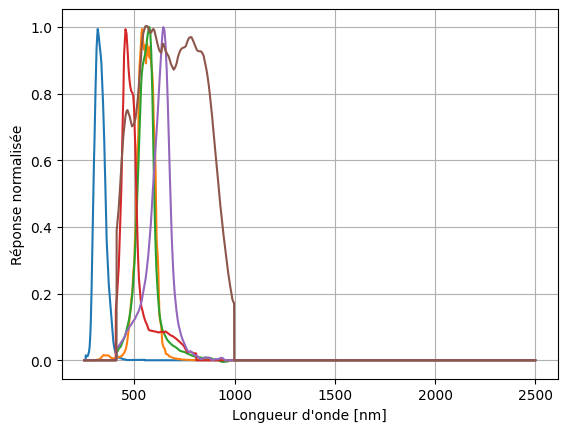

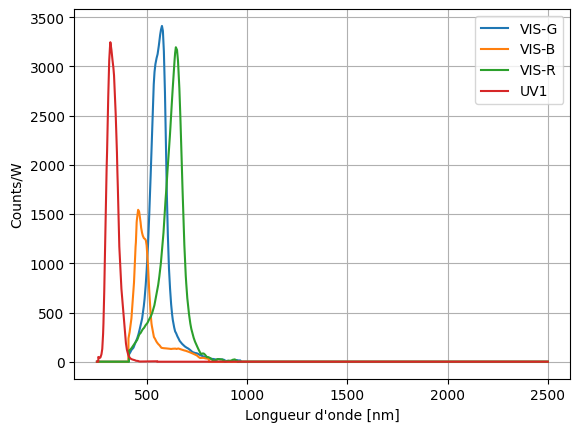

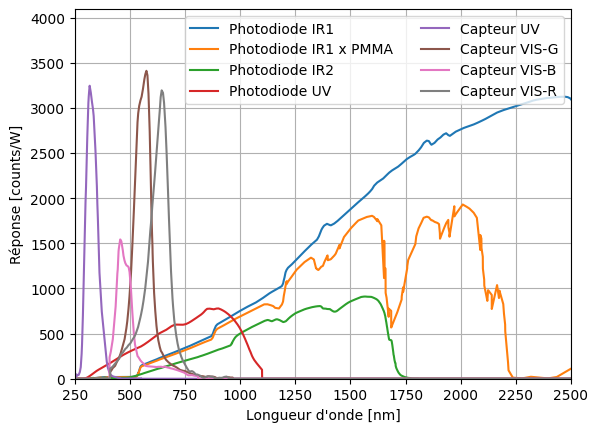

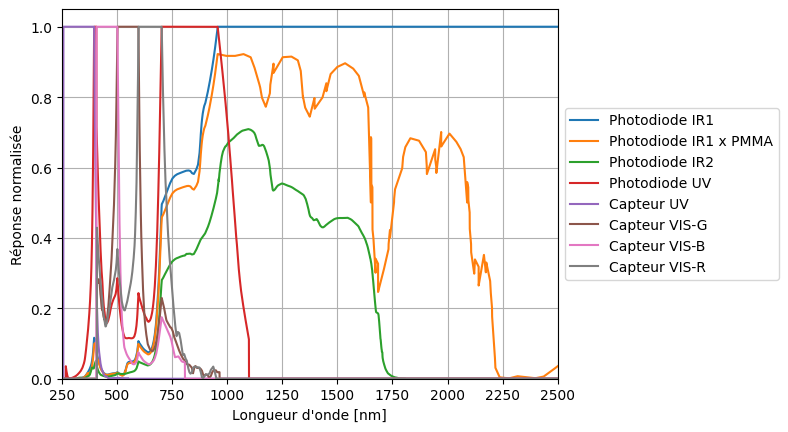

In [52]:
# Charger les fichiers CSV
UV1 = pd.read_csv("UVS.csv")
ALS = pd.read_csv("ALS.csv")
UV2 = pd.read_csv("UV2.csv")
VIS_green = pd.read_csv("Green.csv")
VIS_Blue= pd.read_csv("Blue.csv")
VIS_red = pd.read_csv("Red.csv")
VIS_white = pd.read_csv("White.csv")
IR = pd.read_csv("IR.csv")
IR2 = pd.read_csv("IR2.csv")
PMMA = pd.read_csv("PMMA.csv")
counts_UV1 = pd.read_csv("counts UVS.csv")

Red_sensor_area = (0.2E-3)**2
Green_sensor_area = (0.2E-3)**2
Blue_sensor_area = (0.2E-3)**2
White_sensor_area = (0.2E-3)**2
UV1_sensor_area = (0.28E-3)**2


plt.plot(interpolate_data(UV1)[:, 0], interpolate_data(UV1)[:, 1])
plt.plot(interpolate_data(ALS)[:, 0], interpolate_data(ALS)[:, 1])
plt.plot(interpolate_data(VIS_green)[:, 0], interpolate_data(VIS_green)[:, 1])
plt.plot(interpolate_data(VIS_Blue)[:, 0], interpolate_data(VIS_Blue)[:, 1])
plt.plot(interpolate_data(VIS_red)[:, 0], interpolate_data(VIS_red)[:, 1])
plt.plot(interpolate_data(VIS_white)[:, 0], interpolate_data(VIS_white)[:, 1])
plt.ylabel("Réponse normalisée")
plt.xlabel("Longueur d'onde [nm]")
plt.grid()
plt.show()

# I2C
UV1_interp = denormalize_curve(interpolate_data(UV1), 310, 160/70, 100 / 4e9 * 4095, UV1_sensor_area)
ALS_interp = interpolate_data(ALS)
VIS_green_interp = abs(denormalize_curve(interpolate_data(VIS_green), 518, 74, 100 / 4e11 * 4095, Green_sensor_area)) 
VIS_Blue_interp = denormalize_curve(interpolate_data(VIS_Blue), 467, 56, 100 / 4e11 * 4095, Blue_sensor_area)
VIS_red_interp = denormalize_curve(interpolate_data(VIS_red), 619, 96, 100 / 4e11 * 4095, Red_sensor_area)
VIS_white_interp = interpolate_data(VIS_white)

# Photodiode
UV2_interp = interpolate_data(UV2)
IR_interp = interpolate_data(IR)
IR2_interp = interpolate_data(IR2)
PMMA_interp = interpolate_data(PMMA)
IR_PMMA_interp = interpolate_data(IR)
IR_PMMA_interp[:, 1] = IR_interp[:, 1] * PMMA_interp[:, 1]

counts_UV2 = photodiode_ADC(QE2ApW(UV2_interp), 2)
counts_IR = photodiode_ADC(QE2ApW(IR_interp), 2)
counts_IR_PMMA = photodiode_ADC(QE2ApW(IR_PMMA_interp), 2)
counts_IR2 = photodiode_ADC(QE2ApW(IR2_interp), 2)


# spectral normalisation
IR1, IR1xP, IR2, PUV, CUV, VISG, VISB, VISR = spectral_normalization([ counts_IR, counts_IR_PMMA, counts_IR2, counts_UV2, UV1_interp, VIS_green_interp, VIS_Blue_interp, VIS_red_interp])


# plt.figure(figsize=(10, 4))
# plt.plot(IR_interp[:, 0], IR_interp[:, 1], label='MTPD2601T-100')
# plt.plot(IR_interp[:, 0], IR_PMMA_interp[:, 1], label='MTPD2601T-100 x PMMA') 
# plt.plot(IR2_interp[:, 0], IR2_interp[:, 1], label='MTPD3001D3-030')
# plt.xlabel("Longueur d'onde [nm]")
# plt.ylabel("Efficacité quantique [%]") 
# plt.xlim([250, 2500])
# plt.ylim([0, 0.8])
# plt.legend()
# plt.grid()
# plt.show()


plt.plot(VIS_green_interp[:, 0], VIS_green_interp[:, 1], label='VIS-G')
plt.plot(VIS_Blue_interp[:, 0], VIS_Blue_interp[:, 1], label='VIS-B')
plt.plot(VIS_red_interp[:, 0], VIS_red_interp[:, 1], label='VIS-R')
plt.plot(UV1_interp[:, 0], UV1_interp[:, 1], label='UV1')
plt.grid()
plt.legend()
plt.xlabel("Longueur d'onde [nm]")
plt.ylabel("Counts/W")
plt.show()

plt.plot(counts_IR[:, 0], counts_IR[:, 1], label='Photodiode IR1')
plt.plot(counts_IR_PMMA[:, 0], counts_IR_PMMA[:, 1], label='Photodiode IR1 x PMMA')
plt.plot(counts_IR2[:, 0], counts_IR2[:, 1], label='Photodiode IR2')
plt.plot(counts_UV2[:, 0], counts_UV2[:, 1], label='Photodiode UV')
plt.plot(UV1_interp[:, 0], UV1_interp[:, 1], label='Capteur UV')
plt.plot(VIS_green_interp[:, 0], VIS_green_interp[:, 1], label='Capteur VIS-G')
plt.plot(VIS_Blue_interp[:, 0], VIS_Blue_interp[:, 1], label='Capteur VIS-B')
plt.plot(VIS_red_interp[:, 0], VIS_red_interp[:, 1], label='Capteur VIS-R')

plt.xlabel("Longueur d'onde [nm]")
plt.ylabel("Réponse [counts/W]")
plt.xlim([250, 2500])
plt.ylim([0, 4095])

plt.legend(ncol=2,loc='upper right', fontsize=10)  # 4 colonnes, 2 lignes loc='center left', bbox_to_anchor=(1, 0.5)
plt.grid()
plt.show()

plt.plot(IR1[:, 0], IR1[:, 1], label='Photodiode IR1')
plt.plot(IR1xP[:, 0], IR1xP[:, 1], label='Photodiode IR1 x PMMA')
plt.plot(IR2[:, 0], IR2[:, 1], label='Photodiode IR2')
plt.plot(PUV[:, 0], PUV[:, 1], label='Photodiode UV')
plt.plot(CUV[:, 0], CUV[:, 1], label='Capteur UV')
plt.plot(VISG[:, 0], VISG[:, 1], label='Capteur VIS-G')
plt.plot(VISB[:, 0], VISB[:, 1], label='Capteur VIS-B')
plt.plot(VISR[:, 0], VISR[:, 1], label='Capteur VIS-R')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim([250, 2500])
plt.ylim([0, 1.05])
plt.xlabel("Longueur d'onde [nm]")
plt.ylabel("Réponse normalisée")
plt.show()


c:\Users\cmath\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Erreur absolue moyenne (MAE) : 51.12 nm
Coefficient de détermination (R²) : 0.988


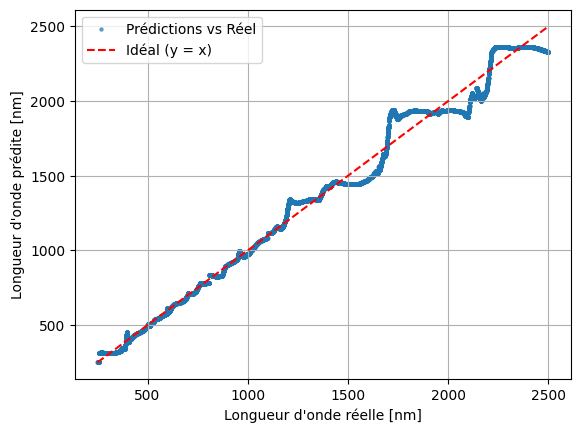

In [43]:
# Créer les données d'entraînement
# X = np.vstack([
#     counts_UV2[:, 1],      
#     counts_IR[:, 1],     
#     counts_IR_PMMA[:, 1],
#     counts_IR2[:, 1]
# ]).T  # Mise en forme pour sklearn (chaque ligne = 1 échantillon)

X = np.vstack([
    IR1[:, 1],
    IR1xP[:, 1],
    IR2[:, 1],
    PUV[:, 1],
    CUV[:, 1],
    VISG[:, 1],
    VISB[:, 1],
    VISR[:, 1]
]).T  # Mise en forme pour sklearn (chaque ligne = 1 échantillon)

y = IR_interp[:, 0]  # Longueur d'onde correspondante

# Séparation des données en train/test (80% entraînement, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlp = MLPRegressor(
    hidden_layer_sizes=(1000, 1000),  # Plus de couches et neurones
    activation='relu',              # 'relu' fonctionne souvent mieux que 'tanh'
    solver='adam',                  # 'adam' fonctionne bien pour des datasets de taille moyenne
    alpha=0.001,                    # Régularisation L2 pour éviter l’overfitting
    learning_rate='adaptive',       # Ajuste le taux d'apprentissage si le modèle stagne
    max_iter=10000,                 # Plus d’itérations pour améliorer la convergence
    random_state=42
)

mlp.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred = mlp.predict(X_test)

# Évaluation des performances
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Erreur absolue moyenne (MAE) : {mae:.2f} nm")
print(f"Coefficient de détermination (R²) : {r2:.3f}")

# Tracer les résultats
plt.scatter(y_test, y_pred, s=5, alpha=0.6, label="Prédictions vs Réel") 
plt.plot([250, 2500], [250, 2500], 'r--', label="Idéal (y = x)")
plt.xlabel("Longueur d'onde réelle [nm]")
plt.ylabel("Longueur d'onde prédite [nm]")
plt.legend()
plt.grid()
plt.show()

In [48]:
def angle_solide_disque(rayon_disque, distance):
    # Calcul du demi-angle au sommet du cône
    theta = np.arctan2(rayon_disque, distance)
    
    # Calcul de l'angle solide
    omega = 2 * np.pi * (1 - np.cos(theta))
    
    return omega   

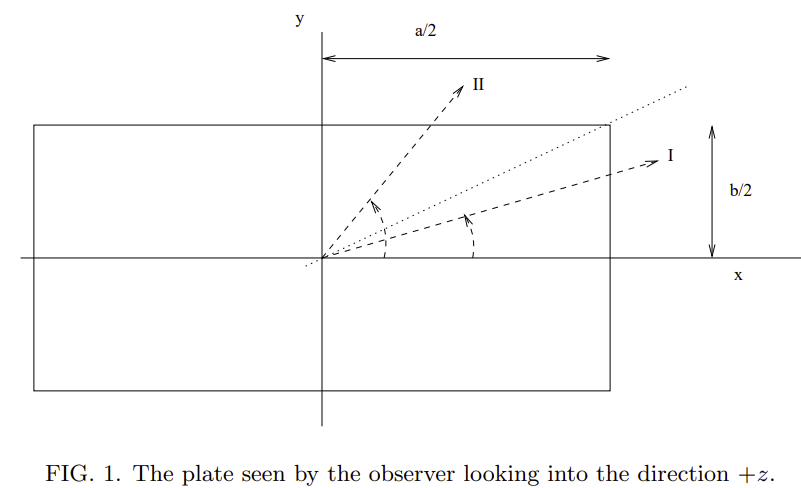

With the definition of two cone parameters $\alpha \equiv a /(2 d)$ and $\beta \equiv b /(2 d)$, the previous equation yields:

$$
\Omega(a, b, d)=4 \arccos \sqrt{\frac{1+\alpha^2+\beta^2}{\left(1+\alpha^2\right)\left(1+\beta^2\right)}}=4 \arctan \frac{\alpha \beta}{\sqrt{1+\alpha^2+\beta^2}} .
$$


[1] Mathar, R. J. (2015). Solid angle of a rectangular plate. Max-Planck institute of astronomy, 1-9.

In [ ]:
def angle_solide_rectangle(longueur, largeur, distance):
    # Demi-dimensions du rectangle
    a = longueur / 2
    b = largeur / 2
    
    alpha = a / (2*distance)
    beta = b / (2*distance)
    
    omega = 4 * np.arctan([alpha * beta / np.sqrt(1 + alpha**2 + beta**2)])
    
    return omega[0]

**Capteur UV : AS7331_T OLGA16 LF T&RDP**

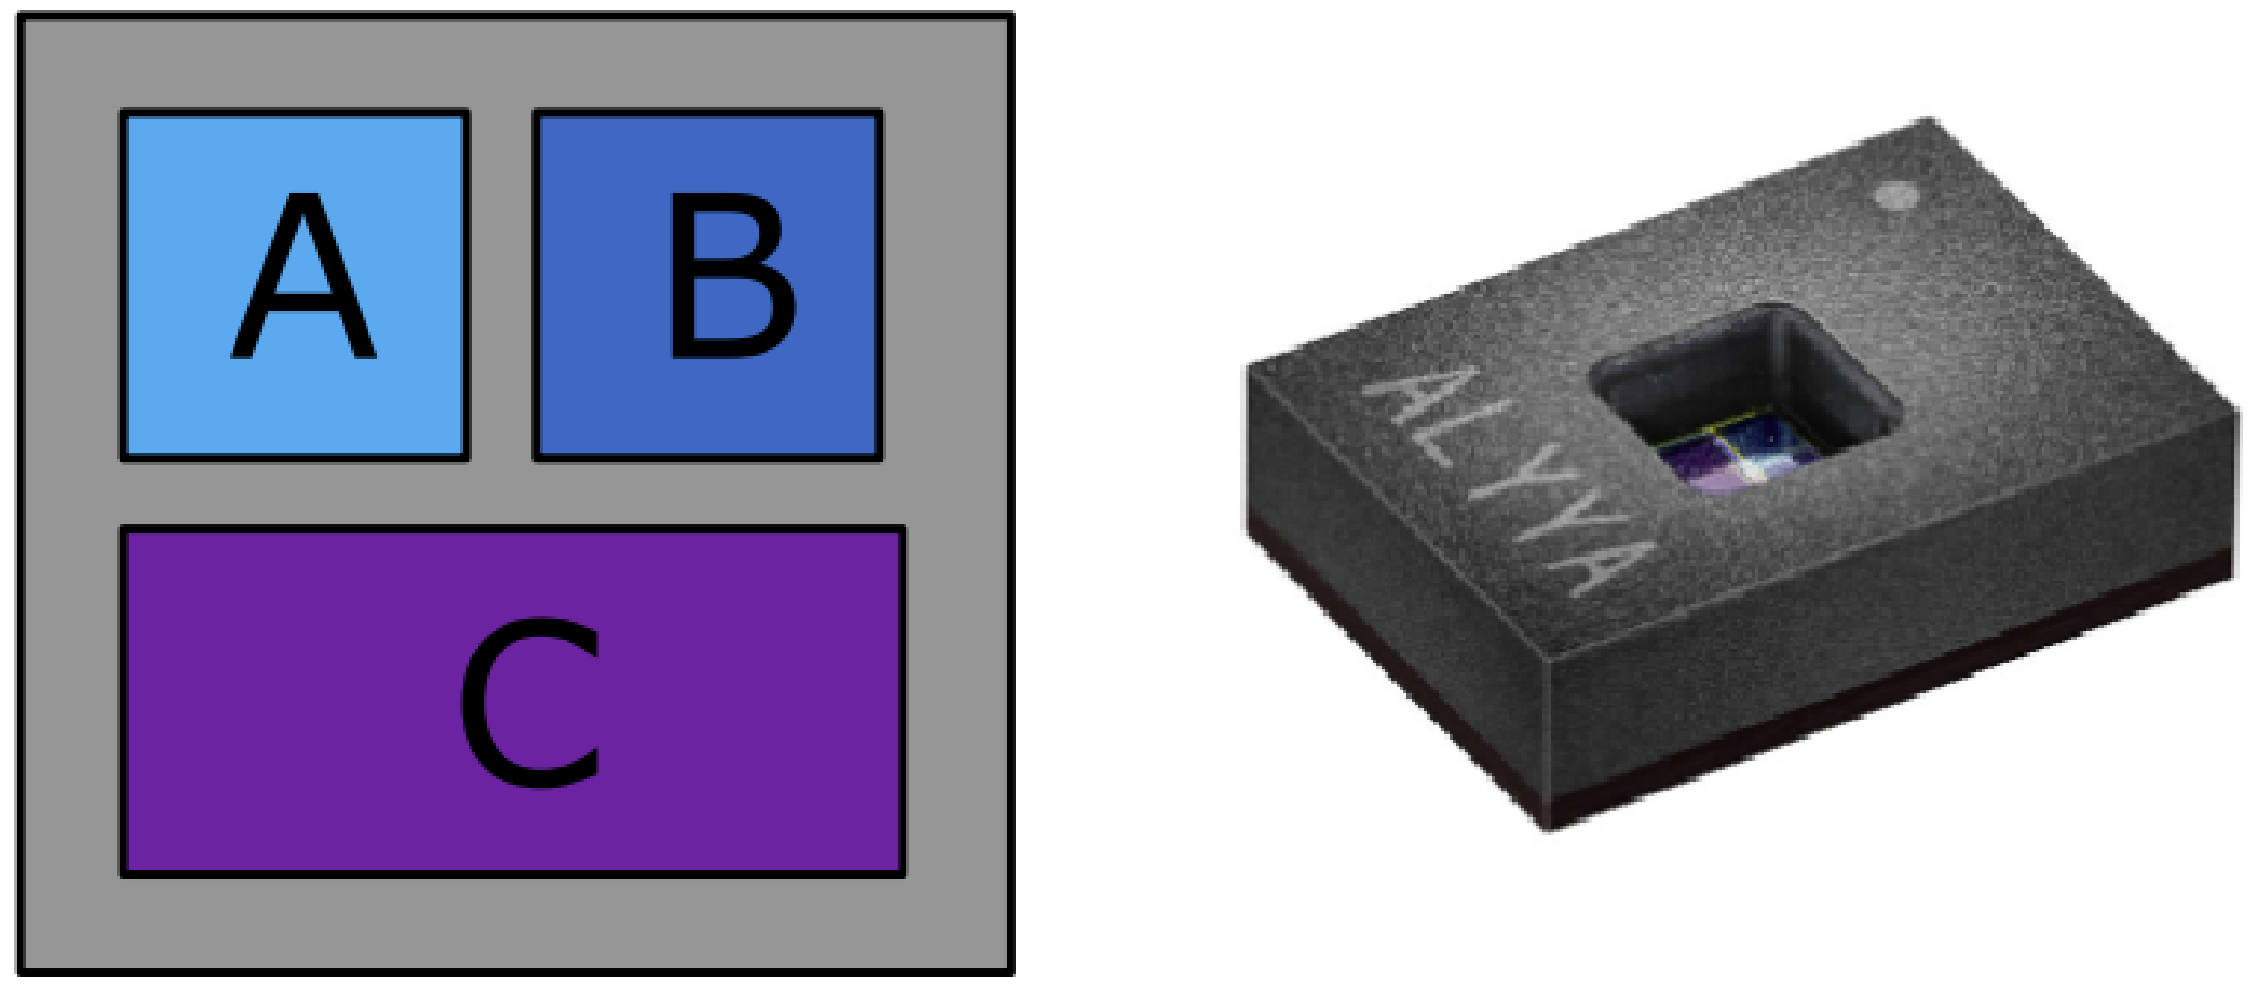

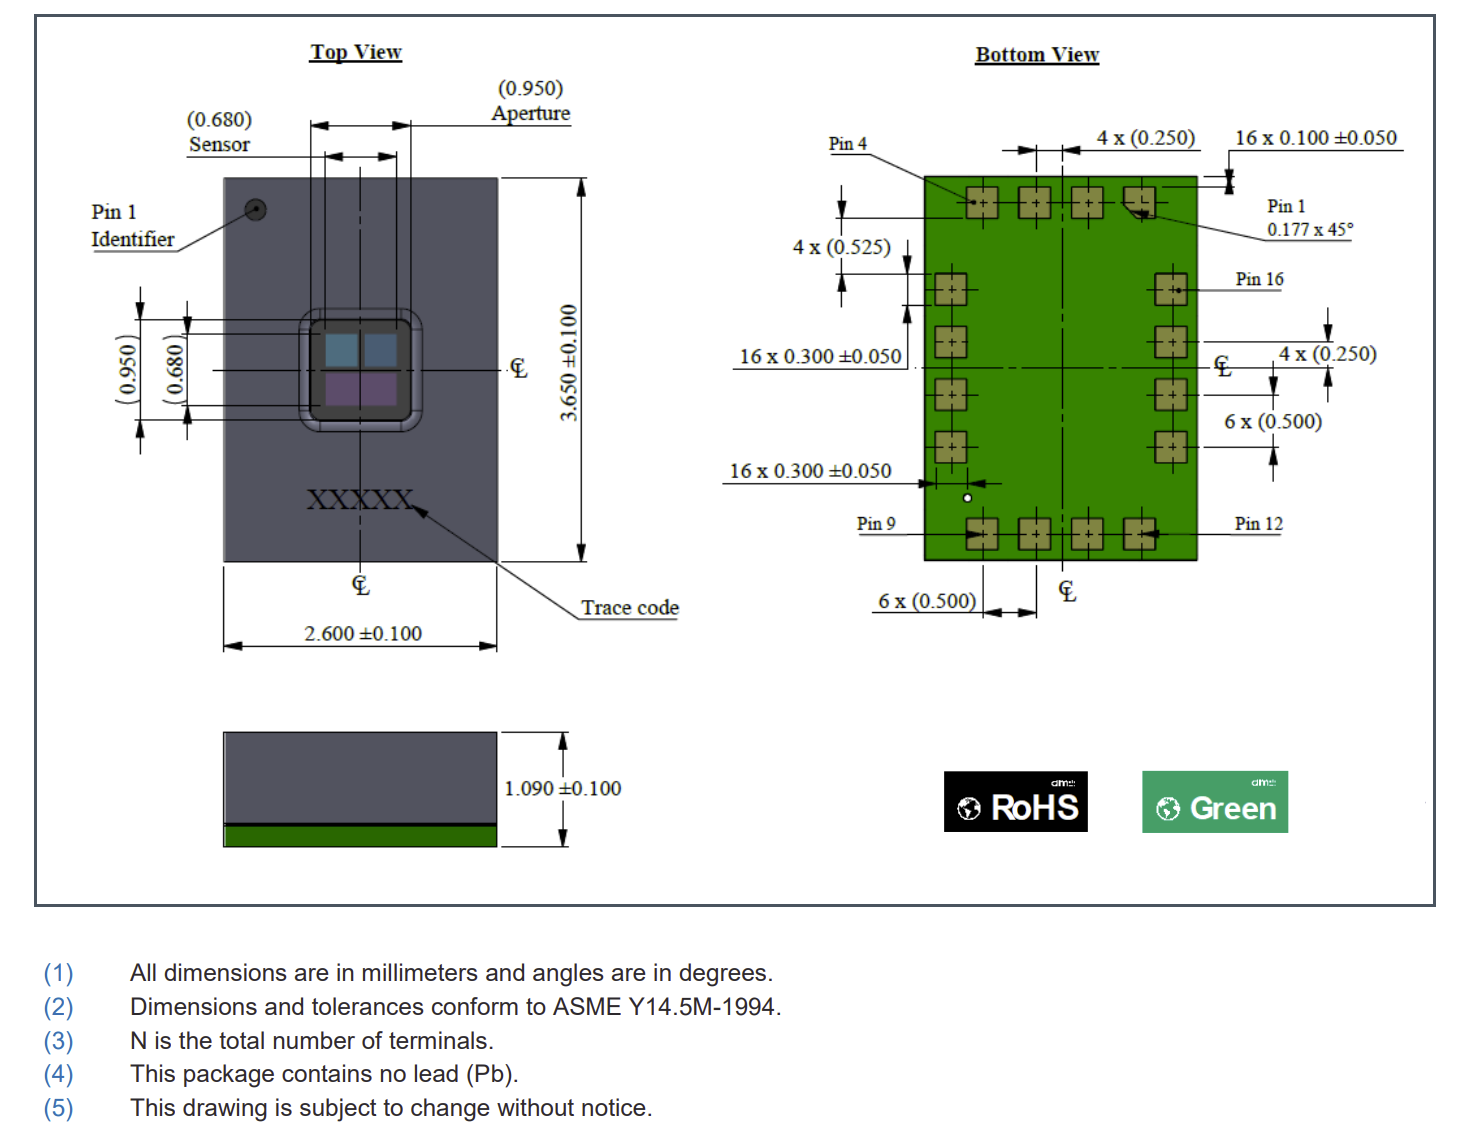

In [ ]:
distance = 20 # [mm]

UVA_largeur = 0.68/2 # [mm]
UVA_hauteur = 0.68/2 # [mm]

UVB_largeur = 0.68/2 # [mm]
UVB_hauteur = 0.68/2 # [mm]

UVC_largeur = 0.68   # [mm]
UVC_hauteur = 0.68/2 # [mm]


angle_sr_UVA = angle_solide_rectangle(UVA_largeur, UVA_hauteur, distance)
angle_sr_UVB = angle_solide_rectangle(UVB_largeur, UVB_hauteur, distance)
angle_sr_UVC = angle_solide_rectangle(UVC_largeur, UVC_hauteur, distance)

print(angle_sr_UVA)

print(f"Angle solide UVA: {angle_sr_UVA/(2*np.pi)*100:.5f}% de 2π stéradians")
print(f"Angle solide UVB: {angle_sr_UVB/(2*np.pi)*100:.5f}% de 2π stéradians")
print(f"Angle solide UVC: {angle_sr_UVC/(2*np.pi)*100:.5f}% de 2π stéradians")

7.224869501187485e-05
Angle solide UVA: 0.00115% de 2π stéradians
Angle solide UVB: 0.00115% de 2π stéradians
Angle solide UVC: 0.00230% de 2π stéradians


**Capteur VIS : LTR-329ALS-01**

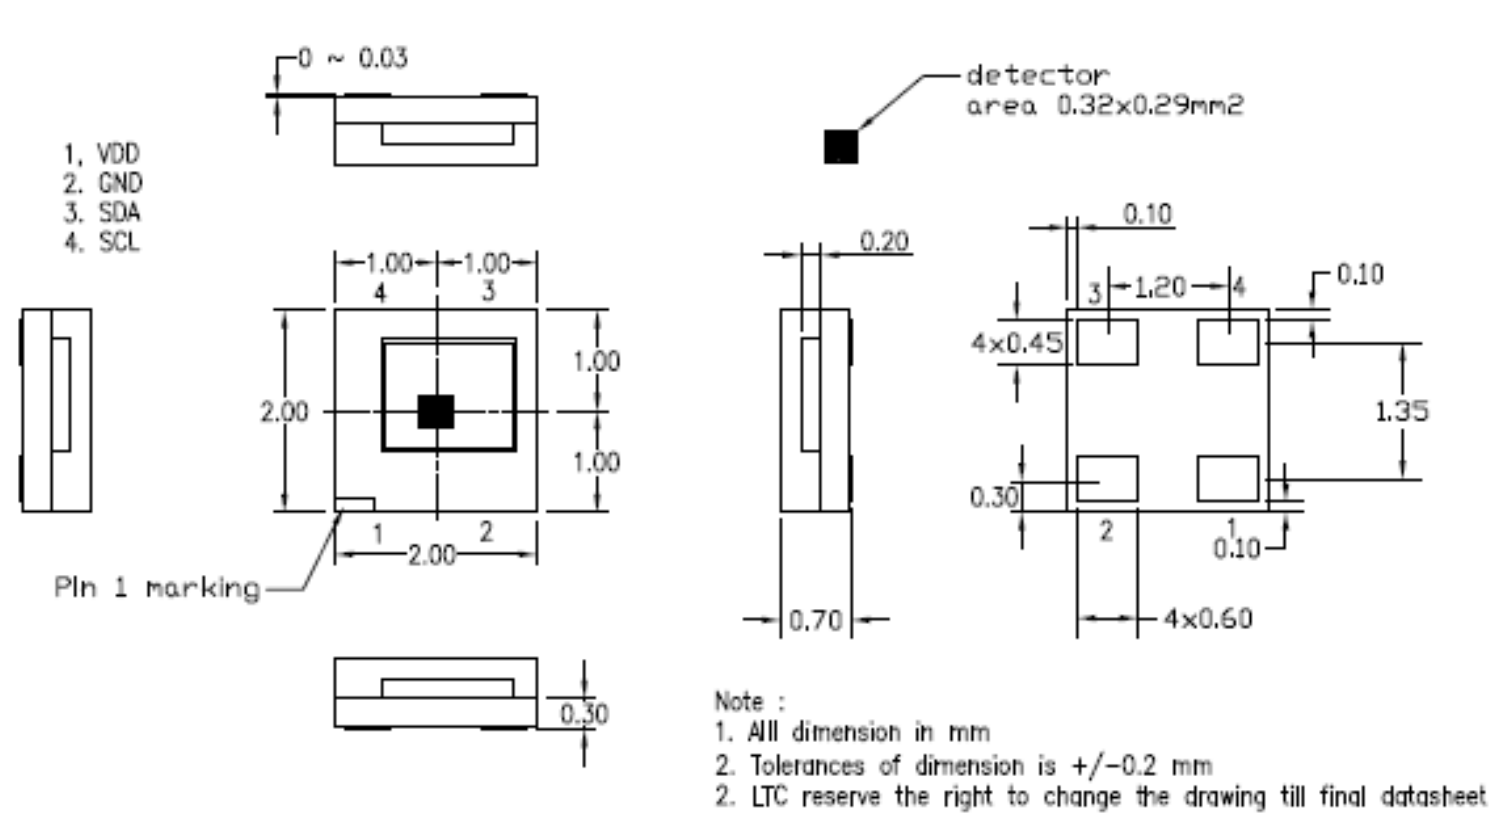



In [ ]:
VIS_Ch0_largeur = 0.32 # [mm]
VIS_Ch0_hauteur = 0.39 # [mm]

VIS_Ch1_largeur = 0.32 # [mm]
VIS_Ch1_hauteur = 0.39 # [mm]

angle_sr_VIS_Ch0 = angle_solide_rectangle(UVA_largeur, UVA_hauteur, distance)
angle_sr_VIS_Ch1 = angle_solide_rectangle(UVB_largeur, UVB_hauteur, distance)

print(f"Angle solide VIS Ch0: {angle_sr_VIS_Ch0/(2*np.pi)*100:.5f}% de 2π stéradians")
print(f"Angle solide VIS Ch0: {angle_sr_VIS_Ch1/(2*np.pi)*100:.5f}% de 2π stéradians")

Angle solide VIS Ch0: 0.00115% de 2π stéradians
Angle solide VIS Ch0: 0.00115% de 2π stéradians


**Capteur IR : MTPD2601T-100**

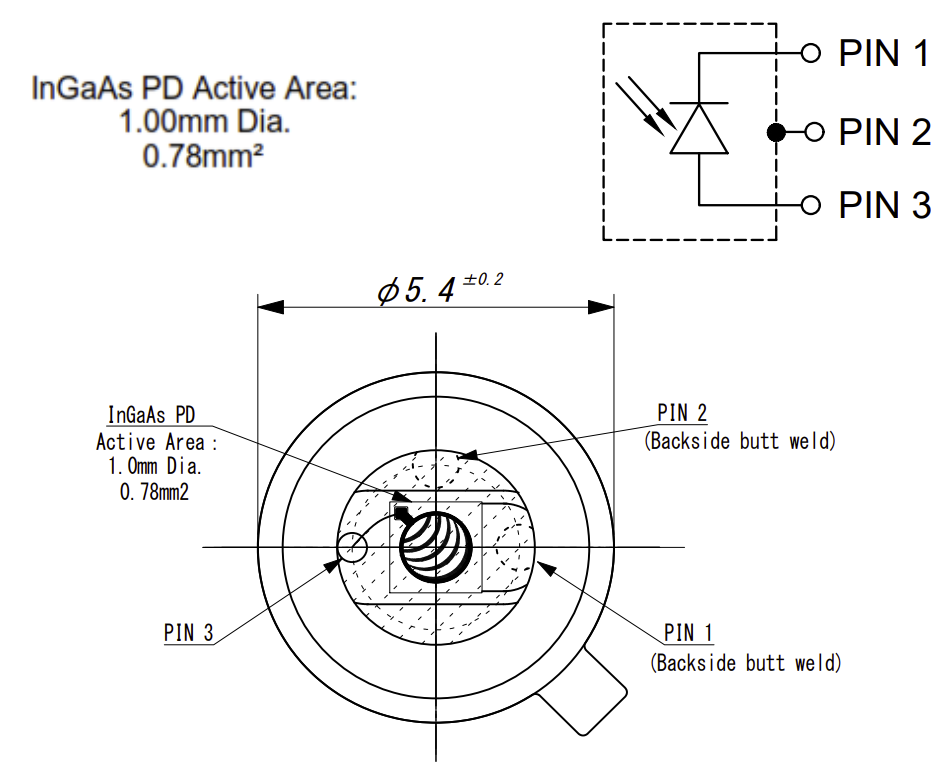

In [ ]:
IR_diametre = 1 # [mm]

angle_sr_IR = angle_solide_disque(IR_diametre/2, distance)

print(f"Angle solide IR: {angle_sr_IR/(2*np.pi)*100:.5f}% de 2π stéradians")

Angle solide IR: 0.03124% de 2π stéradians


**Capteur IR2 : MTPD3001D3-030**
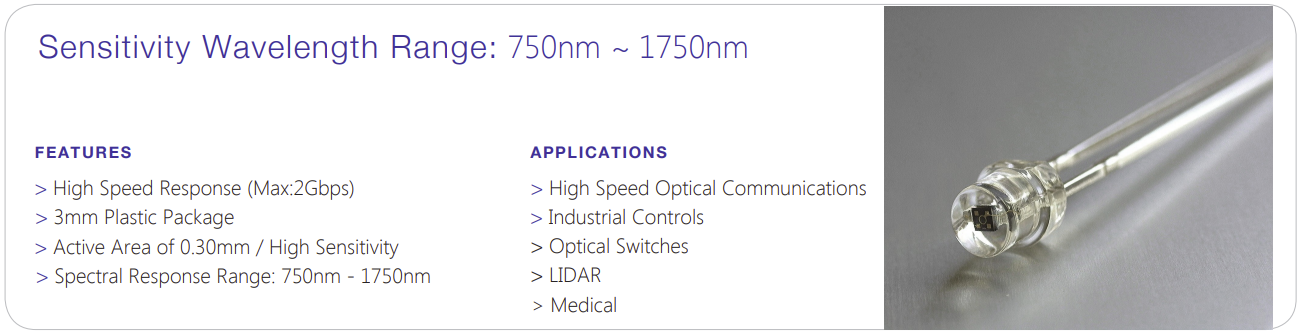

In [ ]:
IR2_largeur = 0.3 # [mm]
IR2_hauteur = 0.3 # [mm]

angle_sr_IR2 = angle_solide_rectangle(IR2_largeur, IR2_hauteur, distance)

print(f"Angle solide IR2: {angle_sr_IR2/(2*np.pi)*100:.5f}% de 2π stéradians")

Angle solide IR2: 0.00090% de 2π stéradians


Supposons un laser incident avec une puissance de 10W réfléchi à 5% sur la surface texturée. On peut calculer la puissance perçue par chaque capteur.

In [ ]:
P = 10 # [W]
R = 5  # [%]

print(f"Puissance laser: {P} W")
print(f"Puissance UVA: {angle_sr_UVA*P*R/100*1000:.4f} mW")
print(f"Puissance UVB: {angle_sr_UVB*P*R/100*1000:.4f} mW")
print(f"Puissance UVC: {angle_sr_UVC*P*R/100*1000:.4f} mW")
print(f"Puissance VIS Ch0: {angle_sr_VIS_Ch0*P*R/100*1000:.4f} mW")
print(f"Puissance VIS Ch1: {angle_sr_VIS_Ch1*P*R/100*1000:.4f} mW")
print(f"Puissance IR: {angle_sr_IR*P*R/100*1000:.4f} mW")
print(f"Puissance IR2: {angle_sr_IR2*P*R/100*1000:.4f} mW")


Puissance laser: 10 W
Puissance UVA: 0.0361 mW
Puissance UVB: 0.0361 mW
Puissance UVC: 0.0722 mW
Puissance VIS Ch0: 0.0361 mW
Puissance VIS Ch1: 0.0361 mW
Puissance IR: 0.9813 mW
Puissance IR2: 0.0281 mW


In [6]:
current_IR = reponse_IR[:, 1] * P * R / 100 * angle_sr_IR
current_IR_PMMA = reponse_IR_PMMA[:, 1] * P * R / 100 * angle_sr_IR
current_IR2 = reponse_IR2[:, 1] * P * R / 100 * angle_sr_IR2

plt.plot(IR_interp[:, 0], current_IR*1000, label='MTPD2601T-100')
plt.plot(IR_interp[:, 0], current_IR_PMMA*1000, label='MTPD2601T-100 x PMMA')
plt.plot(IR2_interp[:, 0], current_IR2*1000, label='MTPD3001D3-030')
plt.xlabel("Longueur d'onde [nm]")
plt.ylabel("Réponse [mA]") 
plt.xlim([250, 2500])
plt.ylim([0, 1.5])
plt.title(f"Courant généré par les photodiodes pour un laser de {P}W absorbé à {100-R}%")
plt.legend()
plt.grid()
plt.show()

NameError: name 'reponse_IR' is not defined

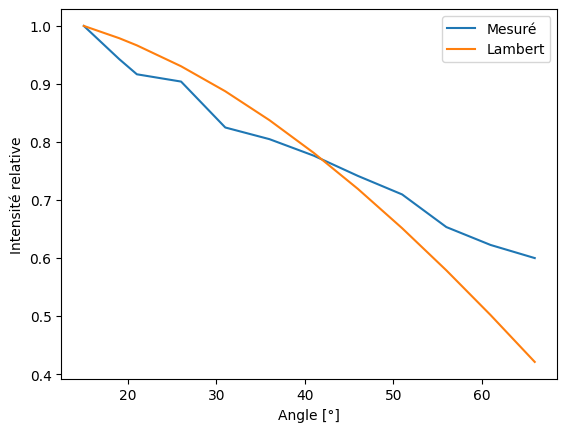

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Test expérimental angle puissance réfléchie 
longueur_onde = 1976E-9        # [m]
distance_detecteur = 0.035  # [m]
puissance_laser = 0.860     # [W]
tension_ref = 148           # [mV]
angle_from_normal = 90 - np.array([75, 71, 69, 64, 59, 54, 49, 44, 39, 34, 29, 24]) # [°]
tension_mesuree = np.array([66, 70, 72, 73, 80, 82, 85, 89, 93, 101, 106, 110]) # [mV]

intensite_rel = (tension_ref / tension_mesuree)/np.max(tension_ref / tension_mesuree)
intensite_lambert = np.cos(np.radians(angle_from_normal)) / np.cos(np.radians(np.min(angle_from_normal)))

plt.plot(angle_from_normal, intensite_rel, label='Mesuré')
plt.plot(angle_from_normal, intensite_lambert, label='Lambert')
plt.xlabel("Angle [°]")
plt.ylabel("Intensité relative")
plt.legend()





$$ I_b\left(\theta_o\right)=\frac{2 \pi F^2 \mu^2}{\left(\cos \theta_i+\cos \theta_o\right)^4}\left(\frac{\lambda}{2 \pi}\right)^2 \frac{1}{\left[1+\frac{\left(\sin \theta_i-\sin \theta_o\right)^2}{\left(\cos \theta_i+\cos \theta_o\right)^4} \mu^2\right]^{3 / 2}}$$
avec
$$ F=\left[1+\cos \left(\theta_i\right.\right.\left.\left.+\theta_o\right)\right] /\left[\cos \theta_i\left(\cos \theta_i+\cos \theta_o\right)\right]$$
et
$$\mu=\mu \mu / 2 \pi \sigma^2$$

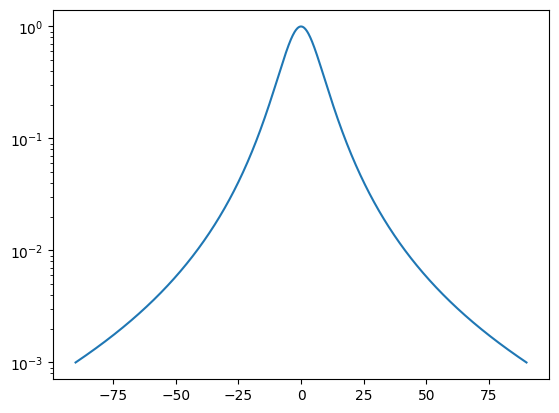

In [3]:
def I_b(theta_i, theta_o, sigma, Lambda, wavelength):
    mu = wavelength * Lambda / (2 * np.pi * sigma**2)
    F = (1 + np.cos(np.radians(theta_i + theta_o))) / (np.cos(np.radians(theta_i)) * (np.cos(np.radians(theta_i)) + np.cos(np.radians(theta_o))))
    F2 = (np.sin(np.radians(theta_i)) - np.sin(np.radians(theta_o)))**2 / (np.cos(np.radians(theta_i)) + np.cos(np.radians(theta_o)))**4
    return (2 * np.pi * F**2 * mu**2) / (np.cos(np.radians(theta_i)) + np.cos(np.radians(theta_o)))**4 * (wavelength / (2 * np.pi))**2 / (1 + mu**2 * F2)**(3/2)

def I_b_normalized(theta_i, theta_o, sigma, Lambda, wavelength):
    I_b_result = I_b(theta_i, theta_o, sigma, Lambda, wavelength)
    return I_b_result / np.max(I_b_result)

plt.semilogy(np.linspace(-90, 90, 1000), I_b_normalized(0, np.linspace(-90, 90, 1000), 200E-9, 10E-6, 633E-9), label='Calculé')


Paramètres optimisés:
mu = 905.915714 nm
Lambda = 9.857515 µm


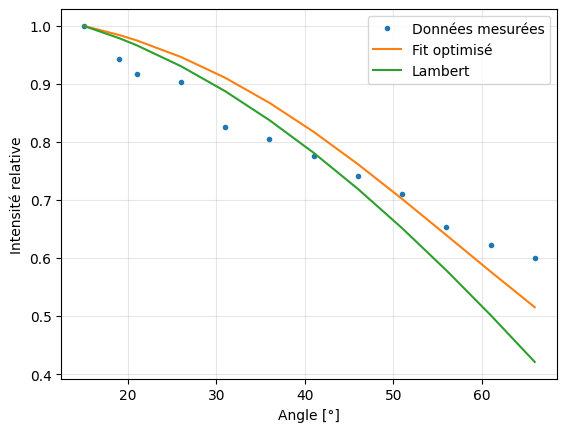

In [5]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


def I_b_wrapper(theta, mu_opt, Lambda):
    thetai = 0  # Fixé à 0
    longueur_donde = 1976e-9  # Fixé à 1976 nm
    return I_b_normalized(thetai, theta, mu_opt, Lambda, longueur_donde)

# Paramètres initiaux pour lambda et Lambda
p0 = [800e-9, 10e-6]  # mu, Lambda

params_opt, cov = curve_fit(
    I_b_wrapper, 
    angle_from_normal, 
    intensite_rel, 
    p0=p0,
    bounds=([100e-9, 1e-7], [2000e-9, 50e-5]),
    maxfev=1000000,
    ftol=1e-10,  # Tolérance sur la fonction
    xtol=1e-10   # Tolérance sur les paramètres
)
# Extraire les paramètres optimisés
mu_opt, Lambda_opt = params_opt

# Afficher les résultats
print(f"Paramètres optimisés:")
print(f"mu = {mu_opt*1e9:.6f} nm")
print(f"Lambda = {Lambda_opt*1e6:.6f} µm")

# Calculer les valeurs prédites avec les paramètres optimisés
intensite_fit = I_b_normalized(0, angle_from_normal, mu_opt, Lambda_opt, 1976e-9)

# Tracer les résultats
plt.plot(angle_from_normal, intensite_rel, 'o', label='Données mesurées', markersize=3)
plt.plot(angle_from_normal, intensite_fit, '-', label='Fit optimisé')
plt.plot(angle_from_normal, intensite_lambert, label='Lambert')
plt.xlabel("Angle [°]")
plt.ylabel("Intensité relative")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

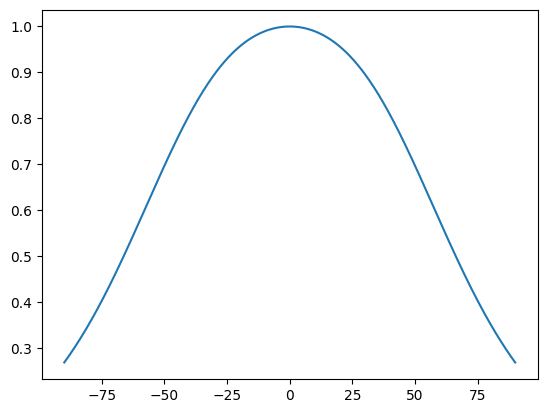

In [14]:
plt.plot(np.linspace(-90, 90, 1000), I_b_normalized(0, np.linspace(-90, 90, 1000), mu_opt, Lambda_opt, 1976E-9), label='Calculé')

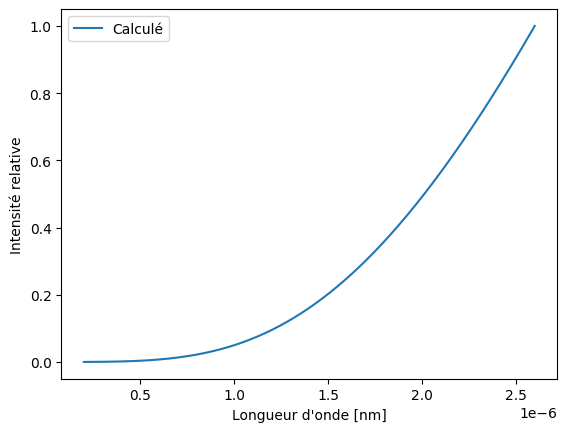

In [16]:
angle_montage = 39 # [°]
longeurs_donde = np.linspace(200e-9, 2600e-9, 1000)

plt.plot(longeurs_donde, I_b_normalized(0, angle_montage, mu_opt, Lambda_opt, longeurs_donde), label='Calculé')
plt.xlabel("Longueur d'onde [nm]")
plt.ylabel("Intensité relative")
plt.legend()